# Introduction

Objective: 
- Develop a tool to detect maturity 
    - test different Canopy Cover thresholds:25, 20, 15, 10 

Strategy: 
- Maturity detection: using Canopy Cover (CC) threshold and day of the year (DOY) when the crop/ plot/ reaches the threshold. 
   
    - convert dates to DOY 
    - interpolate DOYs between flight dates 
    - interpolate the CC values between flight dates / doy
    - remove values that go up after reaching 0 for each plot_id group 
    - create true/ false labels if the value reaches the threshold or not 
    - random forest classfier 
    
    
Assumptions: 
- CC framework:[https://sentera.atlassian.net/wiki/spaces/PM/pages/3204874241/Release+Plot+Canopy+Cover+-+Binaries] 
- values going up after 0 are related to weeds 
- CC goes down when reaching R7, and equals 0 in R8 [https://extension.umn.edu/growing-soybean/soybean-growth-stages#days-between-stages-539862; https://bookstore.ksre.ksu.edu/pubs/MF3339.pdf]
- Assuming no green stem syndrome issues. 



Data example: 

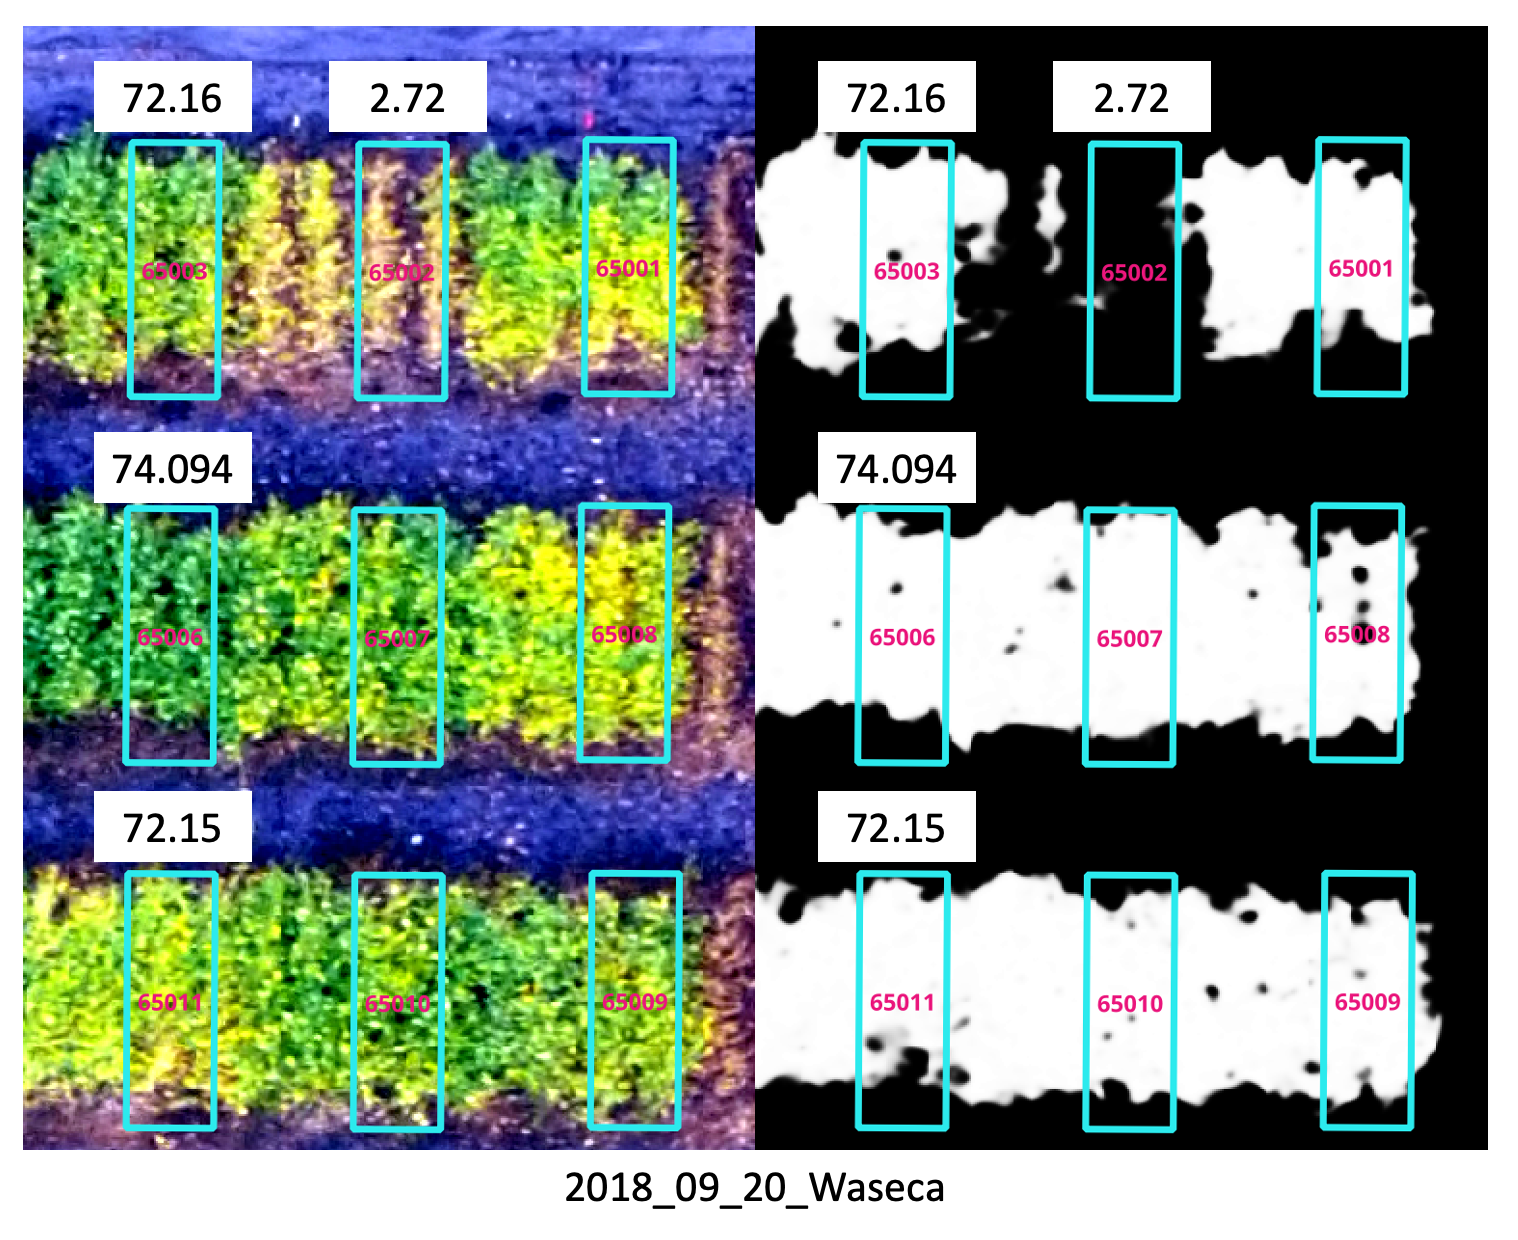

## Workflow 

# Libraries 

In [25]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Code

## Data

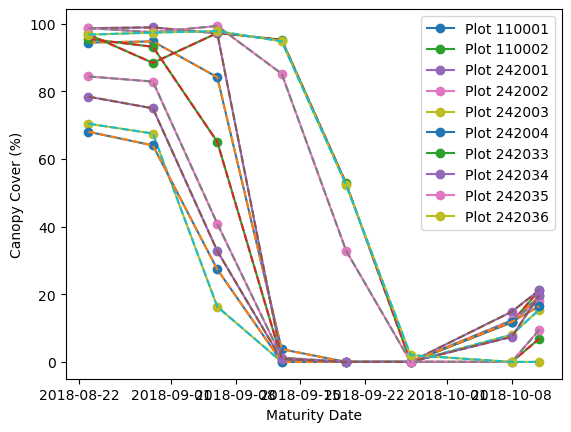

In [58]:

# Read the data from csv file
df = pd.read_csv("cc.csv")

# Convert maturity_date and date to datetime
df["maturity_date"] = pd.to_datetime(df["maturity_date"], format="%Y-%m-%d")
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

# Filter the first 10 plots
df = df[df["plot_id"].isin(df["plot_id"].unique()[:10])]

# Plot the data
fig, ax = plt.subplots()
for plot_id, plot_data in df.groupby("plot_id"):
    ax.plot(plot_data["date"], plot_data["value"], marker='o', label=f"Plot {plot_id}")
    ax.plot(plot_data["date"], plot_data["value"], label="", linestyle='--')
ax.set_xlabel("Maturity Date")
ax.set_ylabel("Canopy Cover (%)")
ax.legend()
plt.show()



In [60]:
df = pd.read_csv("cc.csv")
df.shape

(9440, 13)

In [61]:
# remove values going up after a 0 was present 

grouped = df.groupby('plot_id')

processed_series = []

for name, group in grouped:
    for i in range(0, len(group)-7, 8):
        if (group.iloc[i:i+8]['value'] == 0).any():
            zero_index = group.iloc[i:i+8]['value'].tolist().index(0)
            if any(group.iloc[i:i+8]['value'][zero_index+1:].diff().fillna(0) > 0):
                processed_series.append(group.iloc[i:i+zero_index+2])
        else:
            processed_series.append(group.iloc[i:i+8])
            
new_data = pd.concat(processed_series)
new_data.drop(['Range2', 'Row2', 'Test', 'Entry', 'MNPlot', 'RM', 'RM_list',
       'RepNo',  'measure'], axis=1, inplace=True)

In [62]:
#sanity check
print(new_data.shape)

(5032, 4)


In [63]:
# interpolation using mean, first to complete dates in between flights then to complete values in between values 
df = new_data.copy()
df['date'] = pd.to_datetime(df['date'])
df['maturity_date'] = pd.to_datetime(df['maturity_date'])
df.index = df['date']
del df['date']


In [64]:
new_data.shape

(5032, 4)

In [65]:
df.groupby('plot_id').resample('D').mean().head(40)

/var/folders/qx/b6blh47148117_hdth72j5z00000gp/T/ipykernel_80062/1439359752.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('plot_id').resample('D').mean().head(40)


plot_id    value
plot_id date                        
48001   2018-08-23  48001.0   81.120
        2018-08-24      NaN      NaN
        2018-08-25      NaN      NaN
        2018-08-26      NaN      NaN
        2018-08-27      NaN      NaN
        2018-08-28      NaN      NaN
        2018-08-29      NaN      NaN
        2018-08-30  48001.0   77.138
        2018-08-31      NaN      NaN
        2018-09-01      NaN      NaN
        2018-09-02      NaN      NaN
        2018-09-03      NaN      NaN
        2018-09-04      NaN      NaN
        2018-09-05      NaN      NaN
        2018-09-06  48001.0   53.191
        2018-09-07      NaN      NaN
        2018-09-08      NaN      NaN
        2018-09-09      NaN      NaN
        2018-09-10      NaN      NaN
        2018-09-11      NaN      NaN
        2018-09-12      NaN      NaN
        2018-09-13  48001.0    1.887
        2018-09-14      NaN      NaN
        2018-09-15      NaN      NaN
        2018-09-16      NaN      NaN
        2018-09-17      NaN      NaN
        2018-09-18      NaN      NaN
        2018-09-19      NaN      NaN
        2018-09-20  48001.0    0.000
        2018-09-21      NaN      NaN
        2018-09-22      NaN      NaN
        2018-09-23      NaN      NaN
        2018-09-24      NaN      NaN
        2018-09-25      NaN      NaN
        2018-09-26      NaN      NaN
        2018-09-27  48001.0    0.000
48002   2018-08-23  48002.0  100.000
        2018-08-24      NaN      NaN
        2018-08-25      NaN      NaN
        2018-08-26      NaN      NaN

In [66]:
df_interpol = df.groupby('plot_id').resample('D').mean()
df_interpol['value'] = df_interpol['value'].interpolate()
df_interpol.head(40)

/var/folders/qx/b6blh47148117_hdth72j5z00000gp/T/ipykernel_80062/3640392082.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_interpol = df.groupby('plot_id').resample('D').mean()


plot_id       value
plot_id date                           
48001   2018-08-23  48001.0   81.120000
        2018-08-24      NaN   80.551143
        2018-08-25      NaN   79.982286
        2018-08-26      NaN   79.413429
        2018-08-27      NaN   78.844571
        2018-08-28      NaN   78.275714
        2018-08-29      NaN   77.706857
        2018-08-30  48001.0   77.138000
        2018-08-31      NaN   73.717000
        2018-09-01      NaN   70.296000
        2018-09-02      NaN   66.875000
        2018-09-03      NaN   63.454000
        2018-09-04      NaN   60.033000
        2018-09-05      NaN   56.612000
        2018-09-06  48001.0   53.191000
        2018-09-07      NaN   45.861857
        2018-09-08      NaN   38.532714
        2018-09-09      NaN   31.203571
        2018-09-10      NaN   23.874429
        2018-09-11      NaN   16.545286
        2018-09-12      NaN    9.216143
        2018-09-13  48001.0    1.887000
        2018-09-14      NaN    1.617429
        2018-09-15      NaN    1.347857
        2018-09-16      NaN    1.078286
        2018-09-17      NaN    0.808714
        2018-09-18      NaN    0.539143
        2018-09-19      NaN    0.269571
        2018-09-20  48001.0    0.000000
        2018-09-21      NaN    0.000000
        2018-09-22      NaN    0.000000
        2018-09-23      NaN    0.000000
        2018-09-24      NaN    0.000000
        2018-09-25      NaN    0.000000
        2018-09-26      NaN    0.000000
        2018-09-27  48001.0    0.000000
48002   2018-08-23  48002.0  100.000000
        2018-08-24      NaN   99.839857
        2018-08-25      NaN   99.679714
        2018-08-26      NaN   99.519571

In [67]:
df_interpol.reset_index(level=0, drop=True).to_csv('df_interpol.csv')


In [68]:

df_inter = pd.read_csv('df_interpol.csv')
df_inter['date'] = pd.to_datetime(df_inter['date'])
df_inter['doy_date'] = df_inter['date'].dt.dayofyear
df_inter = df_inter.fillna(method='pad')


In [69]:
df_inter.head(6)

,date,plot_id,value,doy_date
0,2018-08-23,48001.0,81.120000,235
1,2018-08-24,48001.0,80.551143,236
2,2018-08-25,48001.0,79.982286,237
3,2018-08-26,48001.0,79.413429,238
4,2018-08-27,48001.0,78.844571,239
5,2018-08-28,48001.0,78.275714,240


In [70]:
df_inter.shape

(31130, 4)

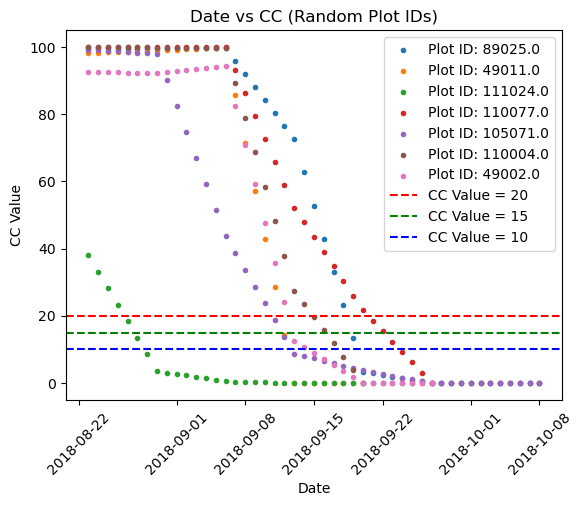

In [72]:

# Group the data by 'plot_id' and select 5 random 'plot_id' values
grouped_data = df_inter.groupby('plot_id')

# Select 5 random 'plot_id' values
random_plot_ids = random.sample(list(grouped_data.groups.keys()), 7)

# Iterate over the selected random 'plot_id' values
for plot_id in random_plot_ids:
    # Get the data for the current 'plot_id'
    plot_data = grouped_data.get_group(plot_id)

    # Plot the data
    plt.scatter(plot_data['date'], plot_data['value'], label=f'Plot ID: {plot_id}', marker='.')
    
plt.axhline(y=20, color='red', linestyle='--', label='CC Value = 20')
plt.axhline(y=15, color='green', linestyle='--', label='CC Value = 15')
plt.axhline(y=10, color='blue', linestyle='--', label='CC Value = 10')
# Adding labels and title
plt.xlabel('Date')
plt.ylabel('CC Value')
plt.title('Date vs CC (Random Plot IDs)')

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a legend to differentiate the lines by plot ID
plt.legend()

# Display the plot
plt.show()

In [73]:
# add the DOY when the condition is met 
df_inter['doy_10cc'] = None
df_inter['doy_15cc'] = None
df_inter['doy_20cc'] = None
df_inter['doy_25cc'] = None

# iterate over the groups 
for group_name, group_data in df_inter.groupby('plot_id'):

    filtered_data_10cc = group_data[group_data['value'] <= 10.0]
    filtered_data_15cc = group_data[group_data['value'] <= 15.0]
    filtered_data_20cc = group_data[group_data['value'] <= 20.0]
    filtered_data_25cc = group_data[group_data['value'] <= 25.0]
    
    # 
    indices_10cc = filtered_data_10cc.index
    indices_15cc = filtered_data_15cc.index
    indices_20cc = filtered_data_20cc.index
    indices_25cc = filtered_data_25cc.index
    
    # 
    df_inter.loc[indices_10cc, 'doy_10cc'] = group_data.loc[indices_10cc, 'doy_date']
    df_inter.loc[indices_15cc, 'doy_15cc'] = group_data.loc[indices_15cc, 'doy_date']
    df_inter.loc[indices_20cc, 'doy_20cc'] = group_data.loc[indices_20cc, 'doy_date']
    df_inter.loc[indices_25cc, 'doy_25cc'] = group_data.loc[indices_25cc, 'doy_date']

# sanity check
print(df_inter)


            date   plot_id      value  doy_date doy_10cc doy_15cc doy_20cc  \
0     2018-08-23   48001.0  81.120000       235     None     None     None   
1     2018-08-24   48001.0  80.551143       236     None     None     None   
2     2018-08-25   48001.0  79.982286       237     None     None     None   
3     2018-08-26   48001.0  79.413429       238     None     None     None   
4     2018-08-27   48001.0  78.844571       239     None     None     None   
...          ...       ...        ...       ...      ...      ...      ...   
31125 2018-10-07  264047.0  18.497636       280     None     None      280   
31126 2018-10-08  264047.0  15.598000       281     None     None      281   
31127 2018-10-09  264047.0  10.979333       282     None      282      282   
31128 2018-10-10  264047.0   6.360667       283      283      283      283   
31129 2018-10-11  264047.0   1.742000       284      284      284      284   

      doy_25cc  
0         None  
1         None  
2         No

In [74]:
#create true or false based on condition:

df_inter['is_mature_10cc'] = df_inter['doy_10cc'].notnull()
df_inter['is_mature_15cc'] = df_inter['doy_15cc'].notnull()
df_inter['is_mature_20cc'] = df_inter['doy_20cc'].notnull()
df_inter['is_mature_25cc'] = df_inter['doy_25cc'].notnull()

#sanity check
df_inter.shape



(31130, 12)

## Classifier 

In [75]:
#Data Split Training and val 


X = df_inter.drop(['date','plot_id', 'doy_date',
             'doy_10cc','doy_15cc', 'doy_20cc', 'doy_25cc', 
             'is_mature_10cc','is_mature_15cc','is_mature_20cc','is_mature_25cc'], axis=1)


y = df_inter['is_mature_10cc']# we can/should discuss which threshold to use 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

print(X)

           value
0      81.120000
1      80.551143
2      79.982286
3      79.413429
4      78.844571
...          ...
31125  18.497636
31126  15.598000
31127  10.979333
31128   6.360667
31129   1.742000

[31130 rows x 1 columns]


In [76]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [77]:
# Calculate accuracy
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, pred)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_test, pred)
print("F1 score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, pred)
print("Confusion matrix:\n", cm)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Confusion matrix:
 [[3868    0]
 [   0 2358]]


In [78]:
import numpy as np

X_new = np.array([[11.00], [5.0], [14.00]])

predictions = model.predict(X_new)

# Las predicciones para los nuevos datos
print(predictions)

[False  True False]


/Users/luciana/anaconda3/envs/geopython/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# Next steps 